# Precision-recall comparison for various scikit-learn estimators 

This notebook shows how various estimators perform on the Titanic dataset in terms of their precision-recall tradeoff. 

Purpose of this notebook is rather educational and the estimators' performance should be taken with reserve as the estimators' hyperparameters are not fine-tuned.

The plot can be used to not only for deciding among estimators, but also to fine-tune an estimator's hyperparameters with respect to the precision-recall schedule.  

Technical note: There are warnings issued during fitting of some of the estimators regarding collinearity among variables. One of the collinearity issues is handled in relation to label binarization (i.e. dummy variable trap), but some other issue seems to prevail and is not currently handled in the code.


In [1]:
#load packages
import sys
import pandas as pd
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn

#Visualization
import matplotlib as mpl
import seaborn as sns
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.utils.testing import all_estimators

from sklearn_pandas import DataFrameMapper, cross_val_score


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
    
class EmbarkedImputer(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return None
    def fit(self, X):
        return self  # nothing else to do
    def transform(self, X):
        # deep copy the df
        df = X.copy()
        
        # Clean up fares.
        value_to_input = df.loc[(df['Fare'] < 85) & (df['Fare'] > 75)  & (df['Pclass'] == 1)]['Embarked'].mode()

        value_to_input = value_to_input[0]

        df.loc[(df['Embarked'].isnull()),['Embarked']] = value_to_input

        return(df)
    
    
class GeneralImputer(BaseEstimator, TransformerMixin):
    def __init__(self, col_impute, col_group, impute_method = 'median'): # no *args or **kargs
        self.col_impute = col_impute
        self.col_group = col_group
        self.impute_method = impute_method
        return None
    def fit(self, X):
        return self  # nothing else to do
    def transform(self, X):
        # deep copy the df because of transform
        df = X.copy()

        # Create a groupby object: by_sex_class
        grouped = df.groupby(self.col_group)

        # function to impute median
        def imputer_median(series):
            return series.fillna(series.median())
        # function to impute average
        def imputer_average(series):
            return series.fillna(series.mean())

        if self.impute_method == 'median':
            # impute median
            df[self.col_impute] = grouped[self.col_impute].transform(imputer_median)
            return(df)
        elif self.impute_method == 'average':
            # impute average
            df[self.col_impute] = grouped[self.col_impute].transform(imputer_average)
            return(df)
        else:
            return np.nan

        
class TitleCreator(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return None
    def fit(self, X):
        return self  # nothing else to do
    def transform(self, X):
        # deep copy the df because of transform
        df = X.copy()

        df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
        df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev','Sir','Jonkheer','Dona'], 'Rare')
        df['Title'] = df['Title'].replace('Mlle', 'Miss')
        df['Title'] = df['Title'].replace('Ms', 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')
        df['Title'] = df['Title'].fillna(np.nan) 

        return(df)
    

CAT_ATTRIBS = ['Sex','Embarked','Title']
NUMERICS_ATTRIBS = ['Pclass','Age','SibSp','Parch','Fare']

#Read train and test data
train = pd.read_csv("../input/train.csv", dtype={"Age": np.float64}, )
test = pd.read_csv("../input/test.csv", dtype={"Age": np.float64}, )


my_mapper = DataFrameMapper([
    ('Sex', sklearn.preprocessing.LabelBinarizer()),
    ('Embarked', sklearn.preprocessing.LabelBinarizer()),
    ('Title', sklearn.preprocessing.LabelBinarizer())
    ], input_df=True)


categorical_data_pipeline = Pipeline([
    ('ebarked_imputer', EmbarkedImputer()),
    ('title_creator', TitleCreator()),
    ('label_binarizer_df', my_mapper),
])



numerical_data_pipeline = Pipeline([
    ('fare_imputer', GeneralImputer(col_impute=['Fare'], 
                                                        col_group=['Sex', 'Pclass'], 
                                                        impute_method='median')),
    ('age_imputer', GeneralImputer(col_impute=['Age'], 
                                                       col_group=['Sex', 'Pclass'], 
                                                       impute_method='average')), # median perhaps?
    ('selector', DataFrameSelector(NUMERICS_ATTRIBS)),
    ('std_scaler', StandardScaler()),
    
])



full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", numerical_data_pipeline),
    ("cat_pipeline", categorical_data_pipeline),
])    

    

train_prepared_0 = full_pipeline.fit_transform(train)
test_prepared = full_pipeline.fit_transform(test)

# drop multicollinear columns
# one column for "embarked", one for "title"
cols_to_drop = [6,9]
train_prepared = np.delete(train_prepared_0, cols_to_drop, axis=1)

# print(train_prepared_0.shape)
# print(train_prepared.shape)
# train_prepared[1:10,5:]


In [2]:
# obtain all available estimators in scikit-learn
estimators = all_estimators()

# declare empty dataframe to save results
y_scores = pd.DataFrame(columns=["value","classifier"])

# itrate over all estimators
for name, class_ in estimators:
    
    # use only estimators with decision function (i.e. with some threshold hyperparameter)
    if hasattr(class_, 'decision_function') and (name not in ["BaggingClassifier", "IsolationForest", "OneClassSVM", "_ConstantPredictor"]):
        print(name)
        
        # fit the classifier on the training data
        clf = class_() 
        clf.fit(train_prepared, train['Survived'])
        
        # create prediction using the training data
        y_score = sklearn.model_selection.cross_val_predict(clf, train_prepared,train['Survived'], cv = 10, method="decision_function")
        
        # pre-process the obtained results and append to the complete results
        new_data = pd.DataFrame({"value" : y_score})
        new_data.insert(0, "classifier", name)
        y_scores = y_scores.append(new_data)
        
        # print(y_score[1:10])

C:\programs_folder\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\programs_folder\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\programs_folder\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  Deprecati

AdaBoostClassifier
GradientBoostingClassifier
LinearDiscriminantAnalysis
LinearSVC
LogisticRegression
LogisticRegressionCV
NuSVC
PassiveAggressiveClassifier
Perceptron
QuadraticDiscriminantAnalysis
RidgeClassifier
RidgeClassifierCV
SGDClassifier


C:\programs_folder\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\programs_folder\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning

SVC


In [3]:
# reshape into a wide format
y_scores_wide = y_scores.assign(index=y_scores.groupby("classifier").value.cumcount()).pivot('index','classifier','value')

# define function to obtain precision and recall from scores and target variable
def precision_recall_wrapper(probas_pred, y_true):
    return(sklearn.metrics.precision_recall_curve(y_true, probas_pred))

# apply the function on the dataframe with scores
metrics = y_scores_wide.apply(precision_recall_wrapper, axis=0, y_true=train['Survived'])


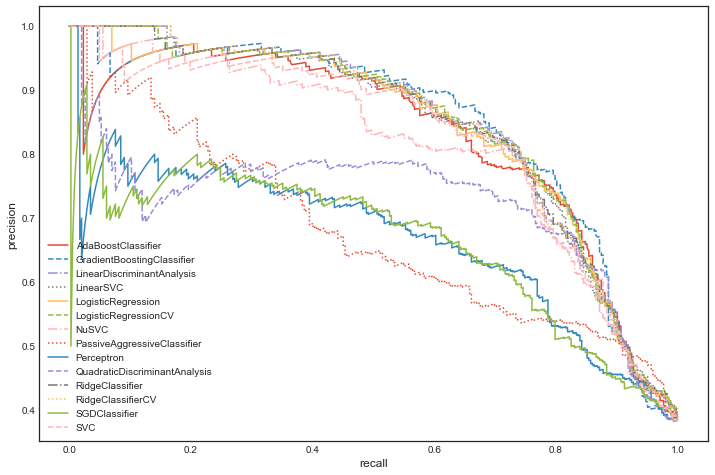

In [5]:
# define linestlyes
linestyles = ['-','--','-.',':']

# iterate over all classifiers
for ind, classifier in enumerate(metrics):

    plt.plot(classifier[1], classifier[0], label = metrics.index[ind], linestyle = linestyles[ind%4])
    
plt.legend(loc='lower left')
plt.xlabel("recall")
plt.ylabel("precision")

Takeaway from the plot:

The estimators are not fine-tuned and therefore the results can not be taken as given. As a general pattern we see decreasing schedules of precision w.r.t. recall (though can be increasing within some interval). Optimal estimator is the one with highest value of a metric, depending on how we evalue (i.e. having fixed precision or recall or the precision-to-recall ratio).